<div align="right" style="text-align: right;"><i>Peter Norvig<br>April 2020</i></div>

# Jotto

[Jotto](https://en.wikipedia.org/wiki/Jotto) is a game in which a **guesser** tries to guess a **target** word, which is chosen from a list of permissible words, in a minimum number of guesses. The **reply** to each guess is the number of letters in common between the guess word and the target word, regardless of the positions of the letters.   

Here is an example Jotto game, where I show the guesses, the replies, the number of possible targets that are consistent with all the guesses/replies seen so far, and finally the letters that matched (this is as an aid to you, the reader; these matching letters are not known to the guesser). In this game, the guesser gets to the target word, "wonky", in 7 guesses. 

    Guess 1: stoma, Reply: 1, Possible targets: 1118    (Matched: "o")
    Guess 2: bairn, Reply: 1, Possible targets: 441     (Matched: "n")
    Guess 3: swipe, Reply: 1, Possible targets: 197     (Matched: "w")
    Guess 4: lurks, Reply: 1, Possible targets: 87      (Matched: "k")
    Guess 5: rowdy, Reply: 3, Possible targets: 14      (Matched: "owy")
    Guess 6: roved, Reply: 1, Possible targets: 2       (Matched: "o")
    Guess 7: wonky, Reply: 5, Possible targets: 1       (Matched: "wonky")



There are several variants of the game; here are my answers to  four key questions:

1. How many letters can each word be? <br>My answer is **only five-letter words**.
2. Can a guess be a word that is not in the word list? <br>My answer is **no**.
1. What is the reply for a word that has the same letter twice, like the `s` in `stars`? <br>My answer is to **disallow such words**.
2. What if the reply is `5`, but the guess is not the target? For example, if the guess is `parse` the
target might be `apres`, `asper`, `pares`, `parse`, `pears`, `reaps`, `spare`, or `spear`. <br>My answer is to **disallow two or more words that are anagrams** of each other; only one such word is allowed in the  word list. 

Typically, the **guesser** plays against a **chooser**, who chooses the target word. This introduces a game-theoretic aspect: the chooser chooses a word that should be difficult for the guesser, but knowing that, the guesser modifies their strategy, and knowing that, the chooser further modifies their choice, etc. To avoid these complications, I will instead use a scenario that eliminates the chooser: the guesser plays against *every* possible target, and we measure the scores from all those games. (This is appropriate when the guesser is a program, but would be extremely tedious for a human guesser.)

We can make a Jotto word list by reading in a file of  words, `sgb-words.txt`, and keeping only those words that have five distinct letters, and only one of the words that share a common anagram form. (But first some imports.)

In [1]:
import matplotlib.pyplot as plt
import random
from typing      import List
from statistics  import mean, stdev
from collections import namedtuple
from math        import log

! [ -e sgb-words.txt ] || curl -O https://norvig.com/ngrams/sgb-words.txt

In [2]:
def jotto_words(words) -> List[str]:
    """Build a list of permissible Jotto words from an iterable of words."""
    anagram_table = {anagram_form(w): w 
                     for w in words if len(w) == 5 == len(set(w))}
    return list(anagram_table.values())

def anagram_form(word) -> str: return ''.join(sorted(word))

wordlist = jotto_words(open('sgb-words.txt').read().split())
len(wordlist)

2845

We see there are 2845 permissible words.

# Playing a Game

We will define the function `play_jotto` to play a game and optionally produce the output shown above in the example game (without the "(Matched: ...)"), and finally return the number of guesses made. To avoid a possible infinite loop with a poor guesser, we impose an upper limit of 1000 guesses for a game.

The first argument to `play_jotto` is a `guesser`. I choose to implement a guesser as a `callable` (e.g., a function) that is passed the current state of the game and returns a guess word. So how do we represent the state of the game? `play_jotto` is keeping track of the `targets` that are still possible given previous guesses and replies, so we might as well pass that in. In addition, we pass in the reply from the previous guess. Note that a guess need not be one of the possible targets, but it must be one of the words in the word list. (If it is not, the guesser forfeits the game, and the score is recorded as the limit.) 

In [3]:
def play_jotto(guesser, target=None, wordlist=wordlist, limit=1000, verbose=False) -> int:
    """How many guesses does it take for the guesser to guess the Jotto target word?"""
    target  = target or random.choice(wordlist)
    targets = wordlist
    reply   = None
    for guesses in range(1, limit + 1):
        guess = guesser(reply, targets)
        if guess not in wordlist:
            return limit
        reply = reply_for(target, guess)
        targets = [w for w in targets if reply_for(guess, w) == reply]
        if verbose: 
            print(f'Guess {guesses}: {guess}, Reply: {reply}, Possible targets: {len(targets)}')
        if guess == target or guesses == limit:  
            return guesses
                         
def reply_for(target, guess) -> int: 
    "The number of letters in common between the target and guess"
    return len(set(target).intersection(guess))

# Random Guesser

One simple guesser function is `random_guesser`: from the possible targets, pick one at random. That sounds naive, but it is actually a decent strategy:

In [4]:
def random_guesser(_, targets) -> str: return random.choice(targets)

play_jotto(random_guesser, verbose=True)

Guess 1: blunt, Reply: 0, Possible targets: 683
Guess 2: exams, Reply: 2, Possible targets: 290
Guess 3: vised, Reply: 2, Possible targets: 120
Guess 4: heard, Reply: 3, Possible targets: 38
Guess 5: redox, Reply: 2, Possible targets: 30
Guess 6: pawed, Reply: 4, Possible targets: 8
Guess 7: waked, Reply: 3, Possible targets: 3
Guess 8: paged, Reply: 4, Possible targets: 2
Guess 9: caped, Reply: 5, Possible targets: 1


9

# Evaluating Guessers

That was just one sample game. How well will this guesser do averaged over all targets? The function `play_jottos` plays a game against every target and collects the scores. Then, `show` displays a histogram and the mean, standard deviation, and maximum values of the scores. 

In [5]:
def play_jottos(guesser, targets=wordlist, wordlist=wordlist) -> List[int]:
    """Scores for this guesser on all targets."""
    return [play_jotto(guesser, target, wordlist, verbose=False)
            for target in targets]
    
def show(scores):
    """Show a histogram and statistics for these scores."""
    scores = list(scores)
    bins = range(min(scores), max(scores) + 2) 
    weights = [1/len(scores)] * len(scores)
    plt.hist(scores, align='left', rwidth=0.9, bins=bins, weights=weights)
    plt.xticks(bins[:-1])
    plt.xlabel('Number of guesses to find target'); 
    plt.ylabel('Proportion of targets')
    print(f'mean = {mean(scores):.2f} ± {stdev(scores):.2f}, max = {max(scores)}')

Since `random_guesser` has a random component, let's evaluate each target multiple times to reduce variance. Let's say 5 times:

mean = 7.37 ± 1.71, max = 18


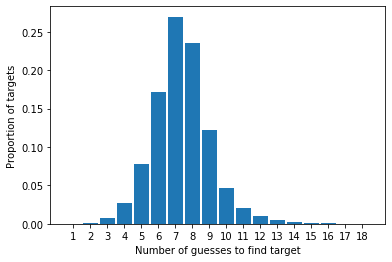

In [6]:
show(play_jottos(random_guesser, targets=5*wordlist))

The average is 7.38 guesses, and most of the time it will take from 6 to 9 guesses. Can we do better than that?

#  Strategies that Partition Targets

It seems that a key idea in guessing is to reduce the number of possible targets. We can think of each guess as **partitioning** the possible targets into different **branches** of a tree, each branch corresponding to a different reply number. Once you get the reply, you can discard all the other branches. 

I will define  `reply_branches(guess, targets)[i]` to give all the target words that yield a reply of `i`, for any `i` from 0 to 5. Similarly, `reply_counts(guess, targets)[i]` gives the number of targets that yield a reply of `i`. The reply counts for every guess (with the full wordlist as targets) are cached in `reply_counts_cache`.

In [7]:
def reply_branches(guess, targets) -> List[str]:
    """A list of [[targets_with_reply_i], ...] for i from 0 to 5."""
    result = [[] for _ in range(6)]
    for target in targets:
        result[reply_for(target, guess)].append(target)
    return result

def reply_counts(guess, targets) -> List[int]: 
    "A list of [number_of_targets_with_reply_i, ...] for i from 0 to 5."
    counts = [0] * 6
    for target in targets:
        counts[reply_for(guess, target)] += 1
    return counts

reply_counts_cache = {guess: reply_counts(guess, wordlist) for guess in wordlist}

I don't want to show `reply_branches` with all 2,845 words, so here it is for the first 20 words of the word list, with the guess `'after'`:

In [8]:
reply_branches('after', wordlist[:20])

[['would', 'cloud', 'sound'],
 ['sword', 'think', 'fondu', 'might'],
 ['about', 'girth', 'place', 'ethos', 'nuder'],
 ['their', 'throe', 'write', 'rifts', 'resay'],
 ['water', 'grate'],
 ['after']]

We see that `'after'` does a pretty good job of partitioning the words into roughly-equal branches.

Below are the reply counts over the full wordlist for two possible guesses, `ouija` and `coder`:

In [9]:
reply_counts_cache['ouija']

[175, 1848, 755, 65, 1, 1]

In [10]:
reply_counts_cache['coder']

[433, 1030, 1014, 327, 40, 1]

We see that for the guess `'ouija'`, there are 1848 possible targets in the `1` branch (the second entry in the counts, because the first entry is for `0`). There are far fewer possible targets in the other branches, so that means that for the majority of targets, you will be left with 1848 possible targets.

For the guess `coder`, the reply will be `1` or `2` for (1030 + 1014) / 2845 = 72% of the targets, and in any case, there will never be more than 1030 possible targets to deal with. That suggests that `coder` is a better first guess, and it suggests a general strategy: **choose the guess that best partitions the possible targets into small branches.**

What's a proper metric for measuring how "small" the branches are? 

- The simplest metric is to **minimize the maximum number in the reply counts**. That is, we should deduce that `coder`, with its `max` reply count of 1030, is a better guess than `ouija`, with its `max` of 1848. 

- A slightly more sophisticated metric is to **minimize the expected number in the reply counts**: the expectation is the sum, over all branches, of the probability of ending up in the branch times the size of the branch.

- Information theory provides a suggestion to **maximize the entropy in the reply counts**. Entropy is similar to expectation, except that it weights each branch size by its base 2 logarithm (whereas expectation weights it by its actual size). Note that we want to minimize *negative* entropy.

In [11]:
def expectation(counts) -> float:
    "Given a list of counts, give the expected count."
    def P(x, scale=1/sum(counts)): return scale * x
    return sum(P(x) * x for x in counts)

def entropy(counts) -> float: 
    """Information theoretic entropy of a list of counts."""
    def P(x, scale=1/sum(counts)): return scale * x
    return - sum(P(x) * log(P(x), 2) for x in counts if x)

def negative_entropy(counts) -> float: return - entropy(counts)

def top(words, metric, n=15) -> str: 
    """The top n words according to metric(reply_counts_cache[w])."""
    return ' '.join(sorted(words, key=lambda w: metric(reply_counts_cache[w]))[:n])

Here are the top 15 words according to each of the three metrics:

In [12]:
# minimize the maximum number in the reply counts
top(wordlist, metric=max)

'wader cadre armed diner coder padre rayed raved delta drone garde eland heard tired debar'

In [13]:
# minimize the expected number in the reply counts
top(wordlist, metric=expectation)

'raved debar roved orbed wader armed fader dater alder cadre garde padre deign gored laved'

In [14]:
# maximize the entropy (by minimizing negative entropy) in the reply counts
top(wordlist, metric=negative_entropy)

'debar alder raved dater cadre armed garde wader lased padre fader dears drone diner rayed'

The three metrics yield a lot of overlap; `wader`, `raved`, and `debar` appear near the top in all three. Which metric is best? We have the tools to answer that: we could use `play_jottos` to get scores for each metric. But that would take a long time, because many computations would be repeated for each target word. We were able to create the `reply_counts_cache` for the words in the complete wordlist, but we really could use a similar cache for all the cases where we have eliminated some of the possible targets.

#  Guesser Trees 

My approach to the cache problem will be to build a **guesser tree**: a tree that partitions target words into branches all the way to the end, where each partition holds a single word. Think of this as a universal strategy that we can precompute once, and then apply to every possible target word with no need for additional complex computation&mdash;just branch-following in the tree.  I define a tree as either:
- A **leaf**, which is a string, such as `'oiuja'`, indicating that this is the sole remaining possible target. Every word in the word list should appear as a leaf in exactly one place in the guesser tree.
- An **interior node**, such as `Node(guess='wader', branches={1: 'oiuja', 5: 'wader'})`, consisting of a guess and branches which are `{reply: tree}` pairs. The node shown here means that we should guess `'wader'` first, and if the reply is `1`, then we're left with the single target `'oiuja'` to guess next, and if the reply is `5`, then we finished the game; `'wader'` was the target.


In [15]:
Leaf = str
Node = namedtuple('Node', 'guess, branches')
Tree = (Node, Leaf) # A Tree is a Node or a Leaf

The function `make_tree` builds a tree that, at every node, chooses the guess that minimizes the value of a metric applied to the reply counts for the guess and the targets. It takes two arguments:
- `metric`, a function that takes a reply count list as input and returns a number;
- `targets`, the list of remaining possible target words. 

In [16]:
def make_tree(metric, targets=wordlist) -> Tree:
    """Make a tree that guesses to minimize or maximize metric(reply_counts(guess, targets))."""
    if len(targets) == 1:
        return targets[0]
    else:
        guess = min(targets, key=lambda guess: metric(reply_counts(guess, targets))) 
        branches = reply_branches(guess, targets)
        return Node(guess, {i: make_tree(metric, branches[i]) 
                            for i in range(6) if branches[i]})

Consider the case where there are five possible targets: `purge`, `bites`, `sulky`, `patsy`, and `hayed`.
Here is a tree to cover those words by, at each node in the tree, making the guess that **minimizes** the **maximum** number in the reply counts list:

In [17]:
words5 = 'purge bites sulky patsy hayed'.split()
tree5  = make_tree(max, words5)
tree5

Node(guess='bites', branches={1: Node(guess='purge', branches={1: Node(guess='sulky', branches={1: 'hayed', 5: 'sulky'}), 5: 'purge'}), 2: 'patsy', 5: 'bites'})


That tree is easier to understand if we reformat it like this:

    Node(guess='bites', 
         branches={1: Node(guess='purge', 
                           branches={1: Node(guess='sulky', 
                                        branches={1: 'hayed', 
                                                  5: 'sulky'}), 
                                     5: 'purge'}), 
                   2: 'patsy', 
                   5: 'bites'})
                   
This says that the first guess is `'bites'`, and if the reply is `1` there is a complex subtree to consider (starting with the guess `'purge'`), but if the reply is `2` the target must be `'patsy'` and of course if the reply is `5` then `'bites'` was the target.

# Turning a Tree into a Callable Guesser

Now that we've made a tree, we need to use it as a component of a guesser that `play_jotto` can call upon. A `TreeGuesser` is an object that stores a tree in the `self.root` and `self.tree` attributes, and while the game is being played, it follows branches in the tree, choosing the guess indicated at each node. This is done within the `__call__` method, because `play_jotto` expects a callable.  Note that whenever the reply is `None`, that indicates the first turn of a new game, in which case we reset `self.tree` to be the root tree. For subsequent turns, we follow the branch indicated by the reply. If the resulting `self.tree` is a `Node` object,  then the `.guess` attribute is the guess; if it is a leaf, then the leaf itself is the guess.

In [18]:
class TreeGuesser:
    """Given a guesser tree, use it to create a callable that can play_jotto."""
    def __init__(self, tree): self.root = self.tree = tree
        
    def __call__(self, reply, _) -> str:
        self.tree = self.root if reply is None else self.tree.branches[reply]
        return guess(self.tree)
    
def guess(tree) -> str: return tree.guess if isinstance(tree, Node) else tree 

Here's how we play a game with the five-word list:

In [19]:
play_jotto(TreeGuesser(tree5), target='sulky', wordlist=words5, verbose=True)

Guess 1: bites, Reply: 1, Possible targets: 3
Guess 2: purge, Reply: 1, Possible targets: 2
Guess 3: sulky, Reply: 5, Possible targets: 1


3

And here we build a tree over the whole word list and use it to play a game:

In [20]:
tree = make_tree(max)
play_jotto(TreeGuesser(tree), verbose=True)

Guess 1: wader, Reply: 0, Possible targets: 466
Guess 2: tings, Reply: 1, Possible targets: 142
Guess 3: hypos, Reply: 0, Possible targets: 8
Guess 4: climb, Reply: 5, Possible targets: 1


4

# Guessing a Nontarget Word

So far,  we have always guessed one of the possible targets. That seems reasonable; why waste a guess on a word that could not possibly be the target? But it turns out that in some cases it *is* a good strategy to guess such a word.

I will redefine `make_tree` so that it is passed both the list of possible target words and the complete word list. It also has a flag, `nontargets`. When this flag is true, any word in the wordlist can be considered as a guess; when false, only target words are considered, as before. (One hack: if there are only three targets or fewer remaining, then it makes no sense to consider a nontarget guess, because it can't possibly decrease the mean score.)

In [21]:
def make_tree(metric, targets=wordlist, wordlist=wordlist, nontargets=False) -> Tree:
    """Make a tree that guesses to minimize or maximize metric(reply_counts(guess, targets)).
    Allow nontarget guesses if `nontargets` is true."""
    if len(targets) == 1:
        return targets[0]
    else:
        candidates = wordlist if nontargets and len(targets) > 3 else targets
        guess = min(candidates, key=lambda guess: metric(reply_counts(guess, targets))) 
        branches = reply_branches(guess, targets)
        return Node(guess, {i: make_tree(metric, branches[i], wordlist, nontargets) 
                            for i in range(6) if branches[i]})

Here we see that by default, `make_tree` behaves just as it did before:

In [22]:
make_tree(max, words5)

Node(guess='bites', branches={1: Node(guess='purge', branches={1: Node(guess='sulky', branches={1: 'hayed', 5: 'sulky'}), 5: 'purge'}), 2: 'patsy', 5: 'bites'})

But when allowed to guess a nontarget word, it comes up with a different tree:

In [23]:
tree5b = make_tree(max, words5, nontargets=True)
tree5b

Node(guess='dashy', branches={0: 'purge', 1: 'bites', 2: 'sulky', 3: 'patsy', 4: 'hayed'})

This tree guesses a nontarget word, `dashy` with the first guess. There is no chance that this is the target, but it sets us up so that we will always be able to get the target on the second guess (so the average score, and the maximum score, is 2):

In [24]:
play_jottos(TreeGuesser(tree5b), words5)

[2, 2, 2, 2, 2]

In [25]:
mean(_), max(_)

(2, 2)

In contrast, the guesser that guesses only target words  has an average score of 2.4, and can take up to four guesses:

In [26]:
play_jottos(TreeGuesser(tree5), words5)

[2, 1, 3, 2, 4]

In [27]:
mean(_), max(_)

(2.4, 4)

So the tree with a nontarget guess is better both in the mean (2.0 versus 2.4) and in the maximum (2 versus 4).



# Comparing Metrics

Now we will compare six guessers derived from `make_tree`:
- Minimizing either `max`, `expectation`, or `negative_entropy`.
- For each of the above, guessing either targets only or targets plus nontargets.

The function `show_metric` makes the appropriate tree and calls `play_jottos` and `show` to display results:

In [28]:
def show_metric(metric, nontargets=False):
    """Show statistics and histogram for a guesser that minimizes `metric` over reply counts."""
    guesser = TreeGuesser(make_tree(metric, nontargets=nontargets))
    show(play_jottos(guesser))

# Comparing Metrics for Target Guesses Only

mean = 7.15 ± 1.81, max = 18
CPU times: user 12.7 s, sys: 28.7 ms, total: 12.8 s
Wall time: 12.8 s


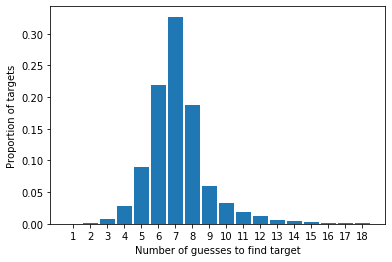

In [29]:
%time show_metric(max, False)

mean = 7.14 ± 1.82, max = 17
CPU times: user 14.2 s, sys: 69.5 ms, total: 14.2 s
Wall time: 14.5 s


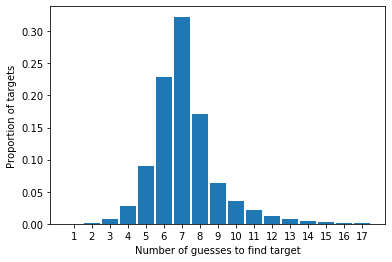

In [30]:
%time show_metric(expectation, False)

mean = 7.09 ± 1.79, max = 19
CPU times: user 12.9 s, sys: 59.3 ms, total: 13 s
Wall time: 13 s


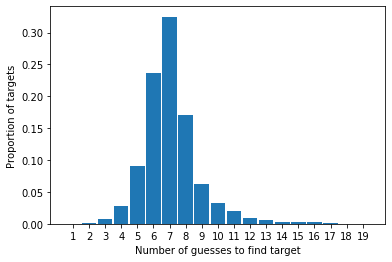

In [31]:
%time show_metric(negative_entropy, False)

# Comparing Metrics with Nontarget Guesses Allowed

mean = 7.05 ± 0.98, max = 10
CPU times: user 32.3 s, sys: 47.2 ms, total: 32.3 s
Wall time: 32.4 s


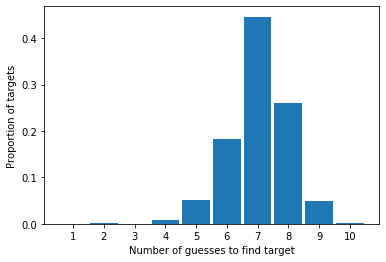

In [32]:
%time show_metric(max, True)

mean = 6.84 ± 0.95, max = 10
CPU times: user 34 s, sys: 66.9 ms, total: 34.1 s
Wall time: 34.3 s


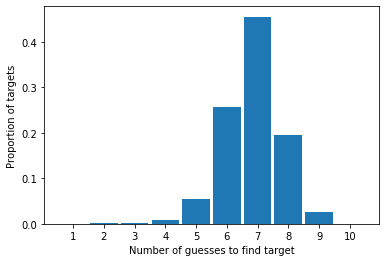

In [33]:
%time show_metric(expectation, True)

mean = 6.81 ± 1.00, max = 10
CPU times: user 34.3 s, sys: 20.8 ms, total: 34.3 s
Wall time: 34.3 s


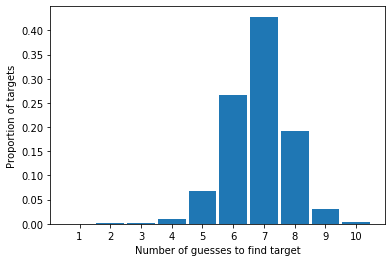

In [34]:
%time show_metric(negative_entropy, True)

# Jotto Summary

Here's a table of results:

|<br>Algorithm|Targets Only<br>Mean (Max)|Nontargets<br>Mean (Max)|
|--|--|--|
|baseline random|7.37 (18)|  |
|min(max(reply_counts))|7.15 (18)|7.05 (10)|
|min(expectation(reply_counts))|7.14 (17)|6.84 (10)|
|max(entropy(reply_counts))|7.09 (19)|6.81 (10)|

So we started out with a mean of 7.37 and a worst score of 18 with the random guesser, and were able to improve by half a guess to a mean of 6.81 and a worst score of 10 using  maximization of entropy over reply counts, with nontarget guesses allowed.

# Next Steps

There are many directions you could take this if you are interested:
- Try different length words.
- Allow words with repeated letters, like `stars`.
- Have each reply consist of two numbers: the number of letters in common with the target, and the number of letters that are in the exact correct position.
- Apply the same techniques to **Mastermind**, which uses the two-number reply system over an alphabet of colors, not letters.
- Examine the strategy that a chooser would use, and how the guesser responds to that. Is there an equilibrium?
- Our `make_tree` function is **greedy** in that it chooses the guess that minimizes (or maximizes) some metric of the current situation without looking ahead to future branches in the tree. Can you get better performance by doing some **look-ahead**?
- Can you improve a tree by editing it? Given a tree, look for interior nodes that have a worse-than-expected average score, and see if the node can be replaced with something better (covering the same target words).
- Research what other computer scientists have done with [Jotto](https://arxiv.org/abs/1107.3342) or [Mastermind](http://serkangur.freeservers.com/).
- What else can you explore?